# Imports and definitions

In [1]:
import EnsembleXAI.Metrics as Metrics
import torchvision.transforms.functional as transform
import torchvision.transforms.functional as F
import torch
from torchvision.transforms import Resize
import os
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import urllib.request
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from torchvision import transforms

In [2]:
with urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    imagenet_classes_dict = json.load(url)

In [3]:
def download_class_images(class_id, masks_path):
    full_path = masks_path + class_id + "\\"
    kaggle_path = f"/ILSVRC/Data/CLS-LOC/train/{class_id}/"
    for file_name in os.listdir(full_path):
        file_name_jpeg = file_name[:-3] + 'JPEG'
        !kaggle competitions download -f {kaggle_path}{file_name_jpeg} -p ./images/{class_id}/ -c imagenet-object-localization-challenge


def images_list(image_path):
    _resizer = Resize([224,224])
    images = []
    for image_name in os.listdir(image_path):
        image = Image.open(image_path + image_name)
        image = _resizer.forward(image)
        images.append(image)
    return images

# Images download

In [4]:
input_dir = "\\".join(os.getcwd().split(sep="\\")[:-2] + ['input'])
masks_dir = input_dir + f'\\ImageNetS50\\train-semi-segmentation\\'
images_dir = os.getcwd() + "\\images\\"

In [ ]:
for class_id in os.listdir(masks_dir):
    image_class_path = os.path.join(images_dir, class_id)
    if os.path.exists(image_class_path) and len(os.listdir(image_class_path)) == 10:
        print(f"Skipped {class_id}")
        continue
    #download_class_images(class_id, masks_dir)
    print(f"Downloaded {class_id}")

In [6]:
id = "n01491361\\"
#id = "n01443537\\"
all_images = images_list(images_dir + id)
all_tensors = [F.to_tensor(img) for img in all_images]
all_masks = [(F.to_tensor(img)>0).float() for img in images_list(masks_dir + id)]
tensor_images = torch.stack(all_tensors)
tensor_masks = torch.stack(all_masks)

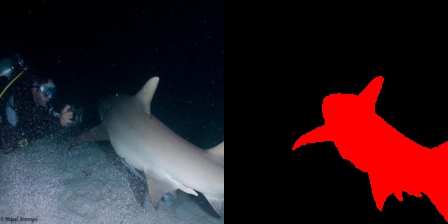

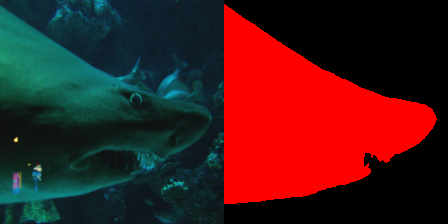

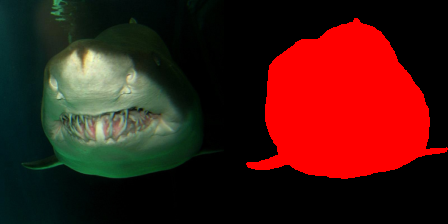

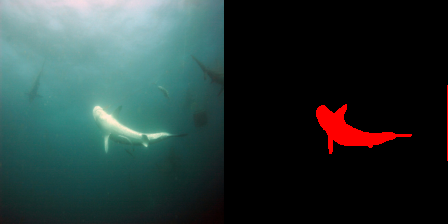

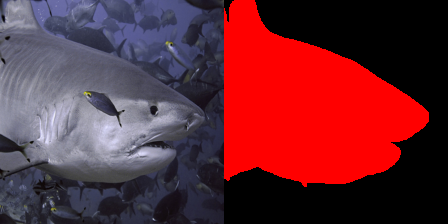

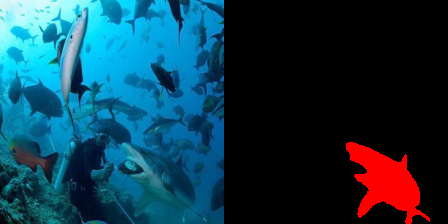

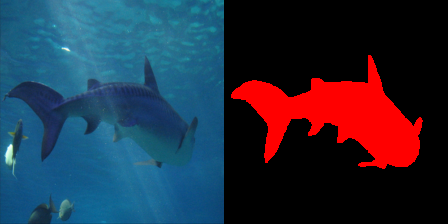

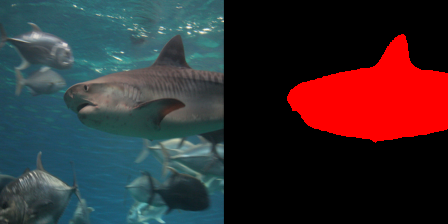

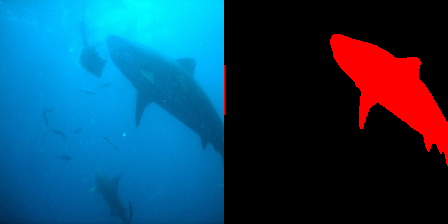

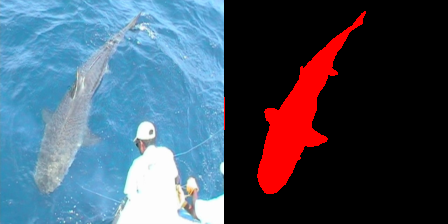

In [7]:
for tensor, mask in zip(all_tensors, all_masks):
    photo = torch.cat([tensor, mask], dim=2)
    display(transform.to_pil_image(photo))

# Model Loading

In [8]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

pipeline = lambda images: torch.stack([transform_normalize(transform(image)) for image in images])
proper_data = pipeline(all_images)

In [9]:
outputs2 = model(proper_data)
_, preds2 = torch.max(outputs2, 1)
probs2 = torch.nn.functional.softmax(outputs2, dim=1)
[imagenet_classes_dict[str(i.item())][1] for i in preds2] # gar = Niszczukokształtne

['hammerhead',
 'tiger_shark',
 'tiger_shark',
 'great_white_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'gar']

# Single Explanations

In [10]:
single_pred = preds2[2].unsqueeze(dim=0)
single_data = proper_data[2].unsqueeze(dim=0)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(single_data, target=single_pred, n_steps=200)

Basing on: https://captum.ai/tutorials/Resnet_TorchVision_Interpret

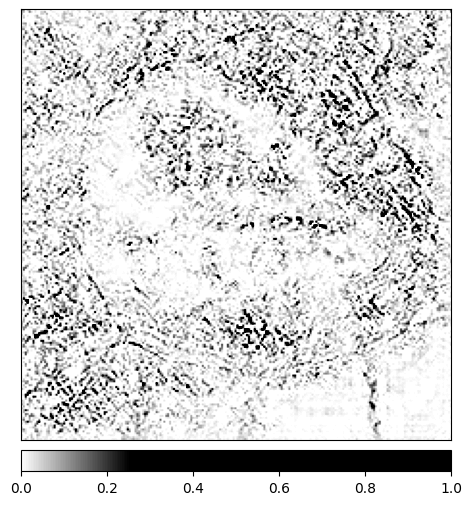

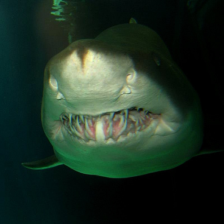

In [11]:
transformed_img = transform(all_images[2])
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
display(all_images[2])

In [12]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(single_data, nt_samples=5, nt_type='smoothgrad_sq', target=single_pred)

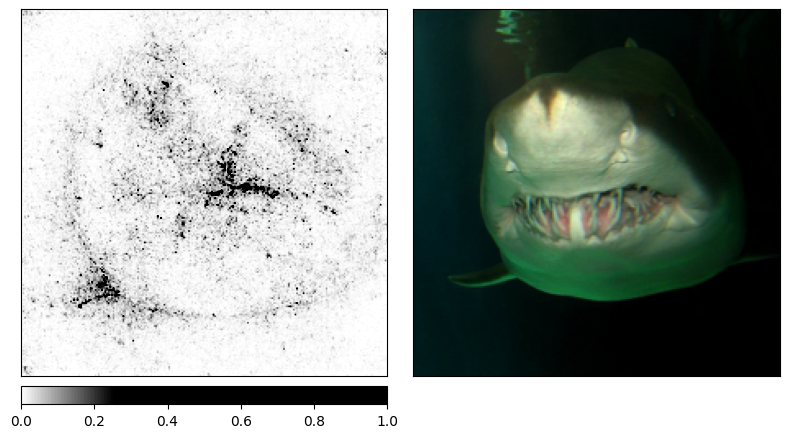

In [13]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [14]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(single_data,
                                       strides = (3, 8, 8),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

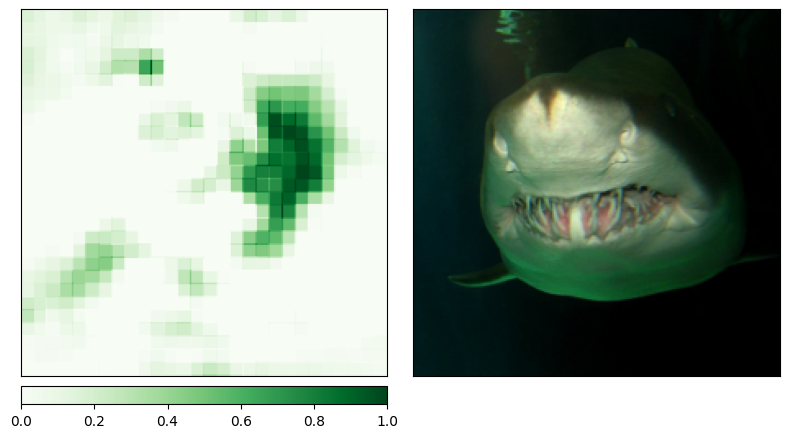

In [16]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

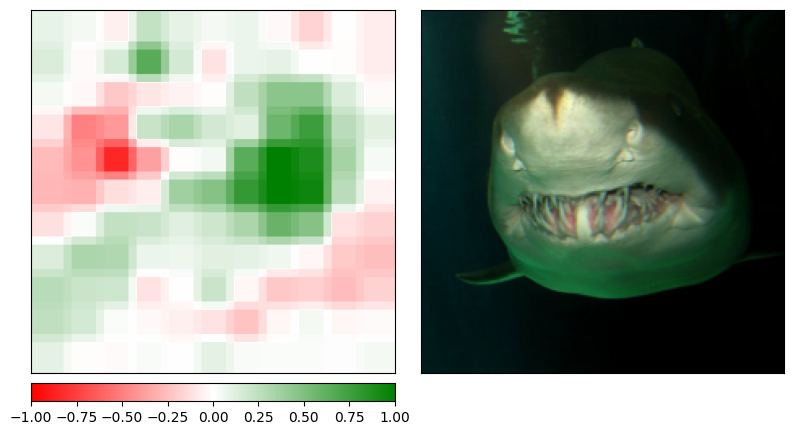

In [17]:
occlusion = Occlusion(model)

attributions_occ2 = occlusion.attribute(single_data,
                                       strides = (3, 20, 20),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 25, 25),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [18]:
occlusion = Occlusion(model)

attributions_occ3 = occlusion.attribute(tensor_images,
                                        strides = (3, 20, 20),
                                        target = preds2,
                                        sliding_window_shapes = (3, 25, 25),
                                        baselines=0)

In [19]:
Metrics.consistency(attributions_occ3)

0.0011080518597736955

In [20]:
Metrics.consistency(torch.cat([attributions_occ, attributions_occ2], dim=0))

0.003380317473784089

In [21]:
predict = lambda x: torch.nn.Softmax(dim=0)(model(x))
Metrics.decision_impact_ratio(tensor_images, predict, attributions_occ3, 0.5, 0)

1.0

In [22]:
Metrics.confidence_impact_ratio(tensor_images, predict, attributions_occ3, 0.5, 0)

0.23103776574134827

In [23]:
Metrics.accordance_recall(tensor_images, tensor_masks[:, 0, :, :])

tensor([1.0000, 1.0000, 0.9959, 1.0000, 1.0000, 0.9611, 1.0000, 1.0000, 0.9684,
        1.0000])

In [24]:
Metrics.accordance_precision(tensor_images, tensor_masks[:, 0, :, :])

tensor([0.1962, 0.4796, 0.5010, 0.0339, 0.4849, 0.0638, 0.1856, 0.2076, 0.1354,
        0.1118])

In [25]:
Metrics.F1_score(tensor_images, tensor_masks[:, 0, :, :])

0.3576756417751312

In [26]:
Metrics.intersection_over_union(tensor_images, tensor_masks[:, 0, :, :])

0.3969152867794037

In [27]:
def sample_xai(images):
    if images.shape[0] == 1:
        target = single_pred
    else:
        target = single_pred.repeat(images.shape[0])
    xai = occlusion.attribute(images,
                              strides = (3, 40, 40),
                              target=target,
                              sliding_window_shapes=(3,50, 50),
                              baselines=0)
    return xai
Metrics.stability(sample_xai, single_data.squeeze(dim=0), single_data.repeat(10,1,1,1))

0.0

# Ensembles

In [30]:
from EnsembleXAI import Ensemble as E
import torchvision.transforms.functional as transform
x = torch.cat([attributions_occ/3, attributions_occ2/3])
aggregated1 = E.aggregate(x, aggregating_func='avg')
aggregated2 = E.aggregate(x, aggregating_func='min')
aggregated3 = E.aggregate(x, aggregating_func='max')

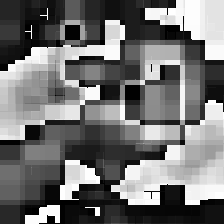

In [34]:
display(transform.to_pil_image(aggregated3[0]))

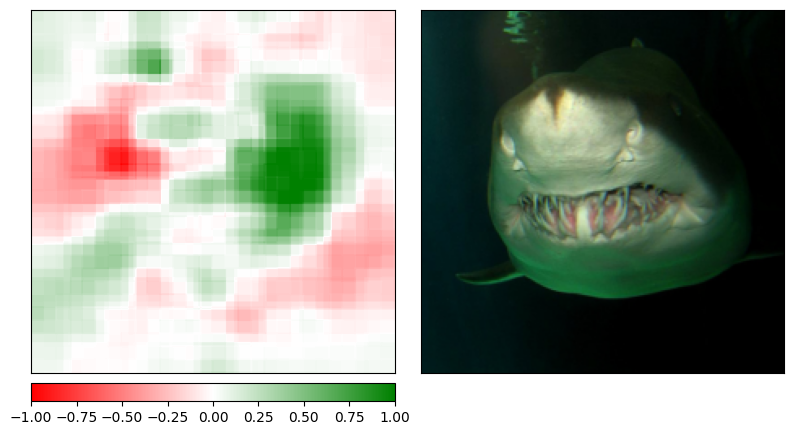

In [31]:
#display(transform.to_pil_image(aggregated1[0]))
_ = viz.visualize_image_attr_multiple(np.transpose(aggregated1.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )